# Analysis of PCB trials
The dataset contains mixed males and females.
The dataset also contains mixed genotypes (wt and sert-Cre hets)
* 2/15/2023 adding a new cohot with PCB given after SEFLB
* There seem to be an effect here but not sure what to make of it since the SEFLB freezing are also different.
* Trying to compare mice w/ equal amount of freezing -> this will not work bc of the high variance in SEFLB
* 6/18/2023 adding normalization with sklearn. _Summary_ so far, the standardization is not so helpful in this case, it is just augment the differences between the treatment groups.
* includes only PTSD16 cohort

In [1]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd /content/sleep/
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 273 (delta 15), reused 20 (delta 8), pack-reused 242
Receiving objects: 100% (273/273), 1.08 MiB | 14.59 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.1-py3-none-any.whl size=1000 sha256=26deb06beb78ad34236c8d02bf3fe990685ab168861b52b00601c3873c3db890
  Stored in directory: /tmp/pip-ephem-wheel-cache-5qb7yne1/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
sns.set_context("talk", font_scale=0.6)

import datetime
%matplotlib inline

from sleep.base import core
from sleep.base import xcorr

In [2]:
dr = core.GoogleDrive()
dr.mount_drive()
save_dir = Path('/gdrive/Shareddrives/Turi_lab/Data/PTSD_project/' \
                '!analysis/saveFolder/Psilocybin')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
raw_data = dr.load_spreadsheet_data('all_cohorts_freezing_FINAL')

In [4]:
# replacing NA to NaN
raw_data.replace('NA', np.NaN, inplace=True)
# changing `freezing` dtype to float
raw_data['freezing'] = pd.to_numeric(raw_data['freezing'],
                                        downcast='float')
# adding unique ID-s based on `id` and `cohort`
raw_data['cohort_id']= raw_data['cohort']+'_'+raw_data['id']

# TODO add DOB-s
# calculate time after SEFLA column
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833 entries, 1 to 1833
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   freezing           1828 non-null   float32
 1   genotype           1833 non-null   object 
 2   id                 1833 non-null   object 
 3   day                1833 non-null   object 
 4   condition          1833 non-null   object 
 5   sex                1833 non-null   object 
 6   cohort             1833 non-null   object 
 7   exposure_mins      1828 non-null   object 
 8   analyzed_duration  1828 non-null   object 
 9   date               1764 non-null   object 
 10  time               1764 non-null   object 
 11  els                1833 non-null   object 
 12  psilocybin         1833 non-null   object 
 13  cohort_id          1833 non-null   object 
dtypes: float32(1), object(13)
memory usage: 193.5+ KB


### List of cohorts included in this analysis

In [5]:
cohort_list = ['ptsd16']
day_list = ['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4']

### All mice

### Filtering out some stuff, like ELS and genotypes other than WT

In [6]:
exp_mice_df = raw_data[(raw_data['cohort'].isin(cohort_list)) &
                              (raw_data['day'].isin(day_list))]
exp_mice_df = exp_mice_df.reset_index()
print(exp_mice_df.groupby(['condition',
                           'psilocybin', 'sex'])['cohort_id'].nunique())
print('\n')
print(exp_mice_df.groupby(['condition',
                           'psilocybin'])['cohort_id'].nunique())

condition  psilocybin  sex 
control    n           male    10
           y           male    10
sefl       n           male    10
           y           male    10
Name: cohort_id, dtype: int64


condition  psilocybin
control    n             10
           y             10
sefl       n             10
           y             10
Name: cohort_id, dtype: int64


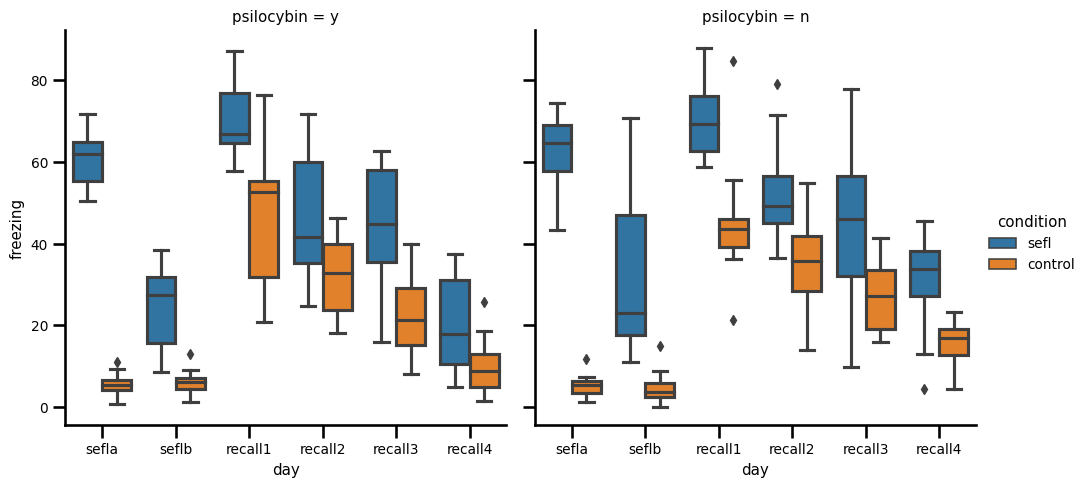

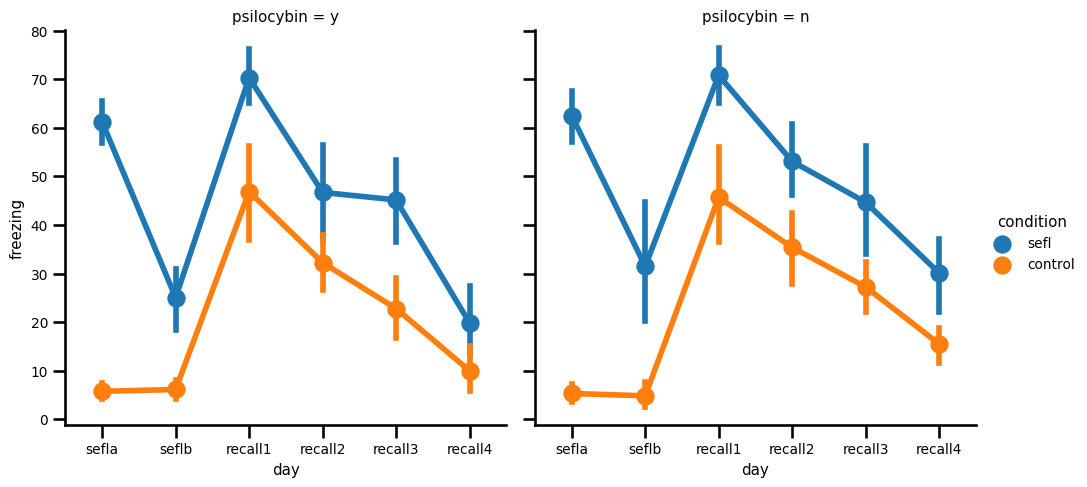

In [7]:
g = sns.catplot(data=exp_mice_df, y='freezing',
                x='day', hue='condition',
                col='psilocybin', kind='box', order=day_list)
g2 = sns.catplot(data=exp_mice_df,
                 y='freezing', x='day', hue='condition',
                col='psilocybin', kind='point', order=day_list)

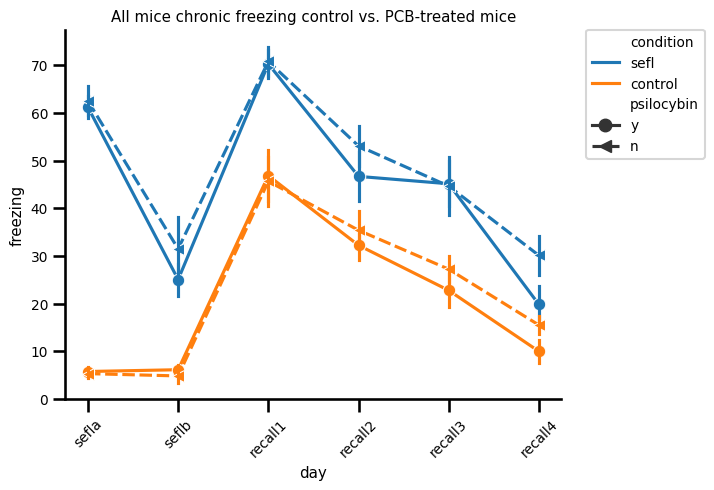

In [8]:
exp_mice_df['day'] = pd.Categorical(exp_mice_df['day'],
                                     categories=day_list,
                                     ordered=True)
g = sns.lineplot(data=exp_mice_df,
                 y='freezing', x='day', hue='condition',
                style='psilocybin', markers=['o', '<'],
                legend=True, err_style='bars', errorbar='se')
plt.title('All mice chronic freezing control vs. PCB-treated mice')
plt.setp(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# plt.savefig(save_dir.joinpath('All mice freezing.png'),
#             bbox_inches='tight', dpi=300)
plt.show()

### Standardizing data

#### Standardscaler

In [9]:
exp_mice_df.columns

Index(['index', 'freezing', 'genotype', 'id', 'day', 'condition', 'sex',
       'cohort', 'exposure_mins', 'analyzed_duration', 'date', 'time', 'els',
       'psilocybin', 'cohort_id'],
      dtype='object')

In [10]:
def scaler(data_frame: pd.DataFrame)-> pd.DataFrame:
  scaler = preprocessing.StandardScaler().set_output(transform="pandas")
  return scaler.fit_transform(data_frame)

In [11]:
sefl_data = exp_mice_df[exp_mice_df['condition']== 'sefl'].pivot(index=['cohort_id', 'psilocybin',
                                   'condition'],
                              columns=['day'],
                              values='freezing')
ctrl_data = exp_mice_df[exp_mice_df['condition']== 'control'].pivot(index=['cohort_id', 'psilocybin',
                                   'condition'],
                              columns=['day'],
                              values='freezing')

scaled_frames = []
for df in [sefl_data, ctrl_data]:
  scaled_frames.append(scaler(df))
scaled_data = pd.concat(scaled_frames, axis=0)
# scaled_data

In [12]:
df = scaled_data.melt(var_name='day', value_name='freezing',
                      ignore_index=False)
df = df.reset_index()
# df

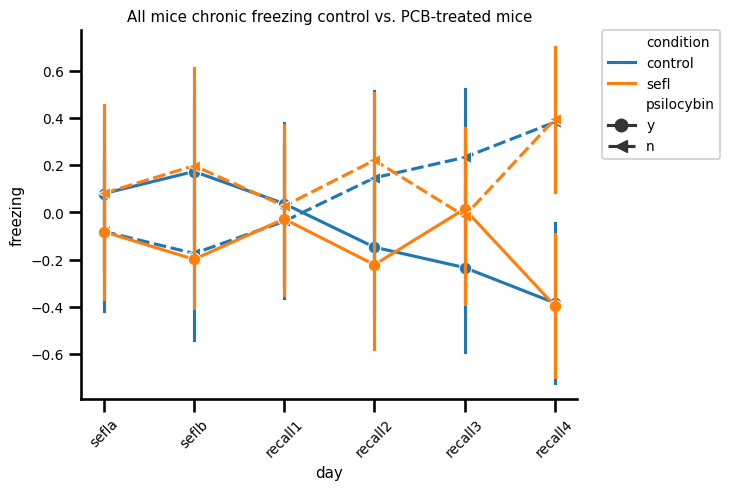

In [13]:
g = sns.lineplot(data=df,
                 y='freezing', x='day', hue='condition',
                 hue_order=['control', 'sefl'],
                style='psilocybin', markers=['o', '<'],
                legend=True, err_style='bars', errorbar='se')
plt.title('All mice chronic freezing control vs. PCB-treated mice')
plt.setp(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# plt.savefig(save_dir.joinpath('All mice freezing.png'),
#             bbox_inches='tight', dpi=300)
plt.show()

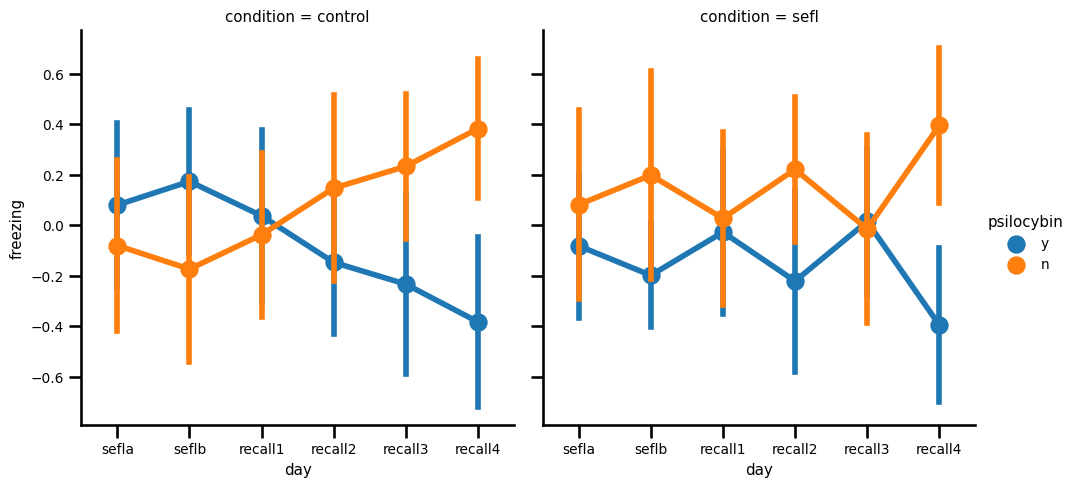

In [14]:
g = sns.catplot(data=df, y='freezing', x='day', hue='psilocybin',
                col='condition', kind='point',
                col_order=['control', 'sefl'], errorbar='se')

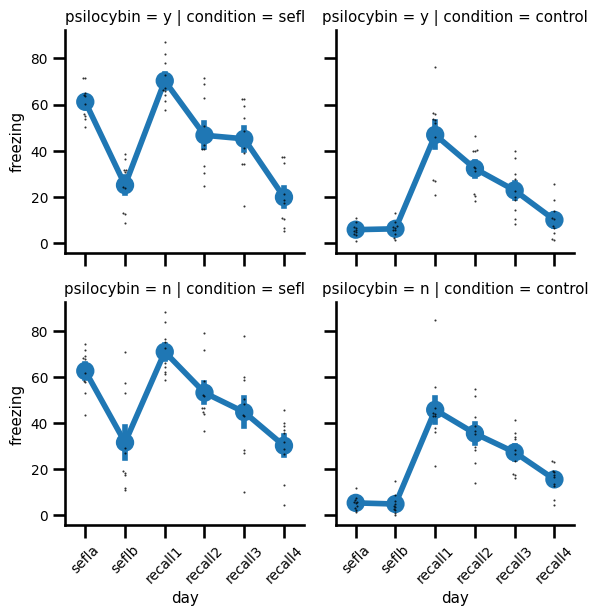

In [15]:
g = sns.FacetGrid(exp_mice_df, col='condition', row='psilocybin')
g.map(sns.pointplot, 'day','freezing', order=day_list, errorbar='se')
g.map(sns.swarmplot, 'day','freezing', alpha=.8, size=1.5, color='k',
      order=day_list)
# g.add_legend()
g.set_xticklabels(labels=day_list, rotation=45)
# g.savefig(save_dir.joinpath('Individual male mice freezing.png'),
#             bbox_inches='tight', dpi=300)

### Standardizing data

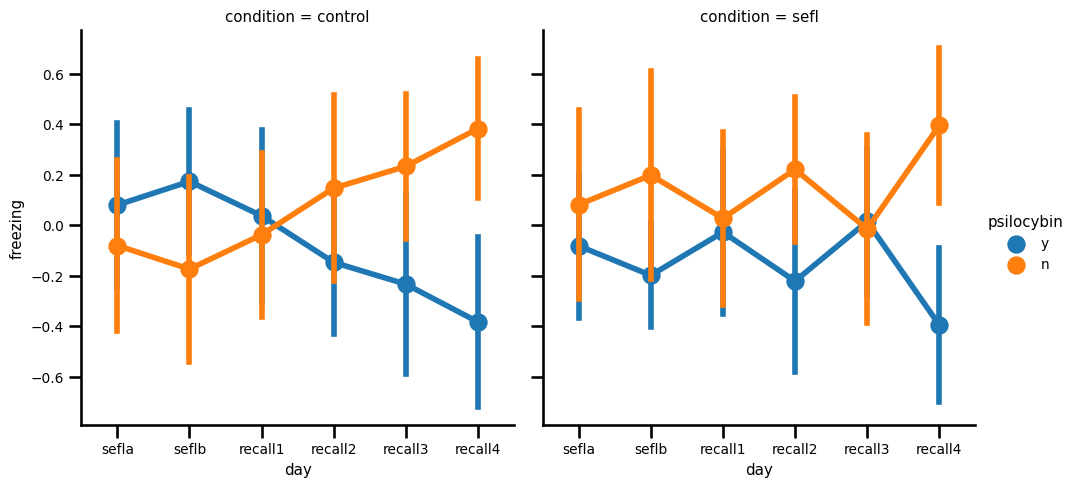

In [16]:
sefl_data = exp_mice_df[exp_mice_df['condition']== 'sefl'].pivot(
    index=['cohort_id', 'psilocybin','condition'],
                              columns=['day'],
                              values='freezing')
ctrl_data = exp_mice_df[exp_mice_df['condition']== 'control'].pivot(
    index=['cohort_id', 'psilocybin', 'condition'],
                              columns=['day'],
                              values='freezing')

scaled_frames = []
for df in [sefl_data, ctrl_data]:
  scaled_frames.append(scaler(df))
scaled_data = pd.concat(scaled_frames, axis=0)

df = scaled_data.melt(var_name='day', value_name='freezing',
                      ignore_index=False)
df = df.reset_index()

g = sns.catplot(data=df, y='freezing', x='day', hue='psilocybin',
                col='condition', kind='point',
                col_order=['control', 'sefl'], errorbar='se')